In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
import imgaug_slices as im
import slices
import slices_config
import voa as val

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Data directory
DATA_DIR = os.path.join(ROOT_DIR, "database")
# Train directory
TRAIN_DIR = os.path.join(DATA_DIR, "train")
# Validate directory
VAL_DIR = os.path.join(DATA_DIR, "validate")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
config = slices_config.Config1()
MODEL_DIR = os.path.join(os.path.join(ROOT_DIR, "logs"),"Config1_mf")
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
config = slices_config.Config1()

In [4]:
config.BATCH_SIZE = 1
config.IMAGES_PER_GPU = 1

In [5]:
dataset_train = slices.SlicesDataset()
dataset_val = slices.SlicesDataset()

In [6]:
channels = ['base','mf']

In [7]:
dataset_train.load_slices(TRAIN_DIR, 3, 40, channels = channels)
dataset_train.prepare()
dataset_val.load_slices(VAL_DIR, 3, 10, channels = channels)
dataset_val.prepare()

processing: image 0
processing: image 1
processing: image 2
processing: image 0
processing: image 1
processing: image 2


In [8]:
mean_pixels = np.zeros(len(channels))
for image_id in dataset_train.image_ids:
    image = dataset_train.load_image(image_id)
    for n in range(len(channels)):
        mean_pixels[n]+= np.mean(image[:,:,n])
mean_pixels = mean_pixels/len(dataset_train.image_ids)
config.MEAN_PIXEL = mean_pixels

In [9]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   2]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [10]:
# Create model in inference mode
model = modellib.MaskRCNN(mode = "inference", 
                          config = config,
                          model_dir = MODEL_DIR)
MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_slices.h5")
print("Loading weights from ", MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)

Loading weights from  C:\Users\Utente\Desktop\slices_segmentation\logs\Config1_mf\mask_rcnn_slices.h5


In [17]:
channel1_path = os.path.abspath("../data/Wafer14/stitched_BF_Test_small.tif")
channel2_path = os.path.abspath("../data/Wafer14/stitched_DAPI_small.tif")
channel1 = skimage.io.imread(channel1_path)
channel2 = skimage.io.imread(channel2_path)
image = np.stack([channel1,channel2],axis=2)

In [19]:
centroids_tissue, centroids_mag, orientations = val.model_confl(model, image, [512, 512], 190, suppress_over_mean = False)

208.87555027008057


In [20]:
%matplotlib notebook

<IPython.core.display.Javascript object>


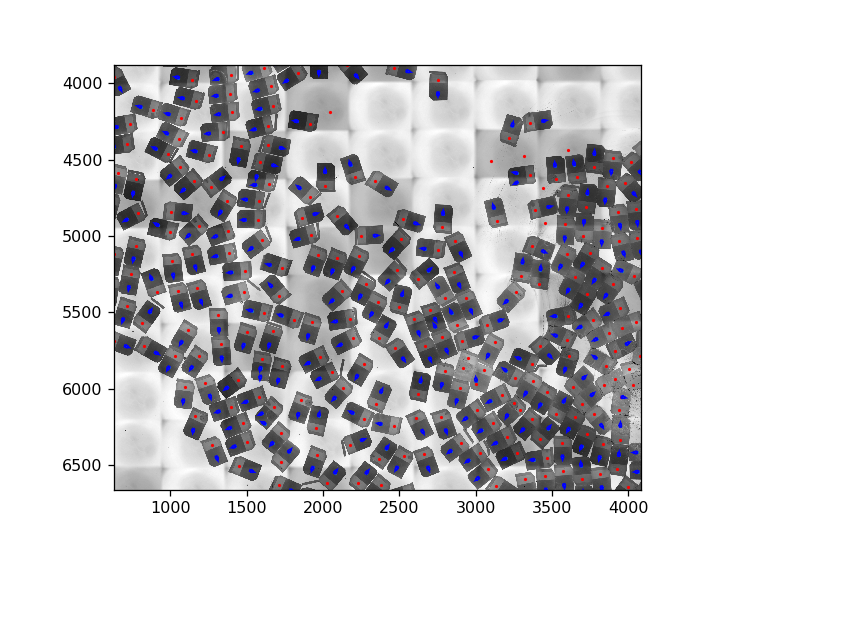

In [21]:
plt.imshow(image[:,:,0],cmap='gray')
plt.scatter(centroids_tissue[:,1],centroids_tissue[:,0], s = 1)
plt.scatter(centroids_mag[:,1],centroids_mag[:,0], s = 1, color='red')
for j in range(centroids_tissue.shape[0]):
    plt.arrow(centroids_tissue[j,1],centroids_tissue[j,0],10*orientations[j,1],10*orientations[j,0], linewidth = 2,color='blue')